In [136]:
import warnings
warnings.simplefilter(action= 'ignore', category=FutureWarning)
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.metrics import recall_score
s3 = boto3.resource('s3')
bucket_name = "rachaeld-data445"
bucket = s3.Bucket(bucket_name)

file_key = 'churn-bigml-80.csv'
file_key2 = 'churn-bigml-20.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

bucket_object2 = bucket.Object(file_key2)
file_object2 = bucket_object2.get()
file_content_stream2 = file_object2.get('Body')

#reading the data-file
telecom_train = pd.read_csv(file_content_stream)
telecom_train.head()
telecom_test = pd.read_csv(file_content_stream2)
telecom_test.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [137]:
#2b 
# replacing churn
telecom_train['Churn'].replace(['Yes', 'No'], [1,0], inplace=True)
telecom_test['Churn'].replace(['Yes', 'No'], [1,0], inplace=True)

#replacing international_plan
telecom_train['International_plan'].replace(['Yes', 'No'], [1,0], inplace=True)
telecom_test['International_plan'].replace(['Yes', 'No'], [1,0], inplace=True)

#replacing voice_mail_plan
telecom_train['Voice_mail_plan'].replace(['Yes', 'No'], [1,0], inplace=True)
telecom_test['Voice_mail_plan'].replace(['Yes', 'No'], [1,0], inplace=True)

telecom_train.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [138]:
#2b cont 
#adding total_charge (sharpsightslab dataframe.assign(name = value))
telecom_train = telecom_train.assign(total_charge = sum([telecom_train['Total_day_charge'], telecom_train['Total_eve_charge'],
                                        telecom_train['Total_night_charge'], telecom_train['Total_intl_charge']]))
telecom_test = telecom_test.assign(total_charge = sum([telecom_test['Total_day_charge'], telecom_test['Total_eve_charge'],
                                        telecom_test['Total_night_charge'], telecom_test['Total_intl_charge']]))
telecom_train.head()


,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,total_charge
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,75.56
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,59.24
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,62.29
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,66.80
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,52.09


In [139]:
# 2c 
# dropping the variables not wanted 
telecom_train = telecom_train.drop(columns = ['State', 'Area_code', 'Number_vmail_messages', 'Total_day_minutes', 'Total_day_calls', 
                                             'Total_day_charge', 'Total_eve_minutes', 'Total_eve_calls', 'Total_eve_charge', 'Total_night_minutes',
                                              'Total_night_calls', 'Total_night_charge', 'Total_intl_minutes', 'Total_intl_calls', 'Total_intl_charge'], axis = 1)
telecom_test = telecom_test.drop(columns = ['State', 'Area_code', 'Number_vmail_messages', 'Total_day_minutes', 'Total_day_calls', 
                                             'Total_day_charge', 'Total_eve_minutes', 'Total_eve_calls', 'Total_eve_charge', 'Total_night_minutes',
                                             'Total_night_calls', 'Total_night_charge', 'Total_intl_minutes', 'Total_intl_calls', 'Total_intl_charge'], axis = 1)
telecom_train.head()


,Account_length,International_plan,Voice_mail_plan,Customer_service_calls,Churn,total_charge
0,128,0,1,1,False,75.56
1,107,0,1,1,False,59.24
2,137,0,0,0,False,62.29
3,84,1,0,2,False,66.80
4,75,1,0,3,False,52.09


In [140]:
# 2d1
X = telecom_train[['Account_length', 'International_plan', 'Voice_mail_plan', 'Customer_service_calls', 'total_charge']]
Y = telecom_train['Churn']


In [141]:
data = list()
for i in range (0,1000):
    # splitting data
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = .2, stratify = Y)
    
    # min-max transformation
    scaler = MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    # estimating lanbda for lasso
    lasso_cv = LassoCV(normalize = True, cv= 5).fit(X_train, Y_train)
        
    # extracting the best lambda
    cv_lambda = lasso_cv.alpha_
    
    # building lasso model
    lasso_md = Lasso(alpha= cv_lambda, normalize = True).fit(X_train,Y_train)
    data.append(lasso_md.coef_)
    
data = pd.DataFrame(data)
data


,0,1,2,3,4
0,0.000000,0.306893,-0.068582,0.476423,0.502672
1,0.054437,0.292123,-0.066844,0.588293,0.519487
2,0.017223,0.334731,-0.063978,0.517505,0.482969
3,0.018425,0.316899,-0.076270,0.571569,0.513550
4,0.042077,0.312217,-0.068289,0.511291,0.511982
...,...,...,...,...,...
995,-0.023840,0.322179,-0.082482,0.457826,0.471261
996,0.000000,0.309733,-0.065629,0.490526,0.520544
997,0.073617,0.339805,-0.079974,0.579973,0.499734
998,0.020504,0.329910,-0.072295,0.495423,0.483979


In [142]:
print(sum(data[0] == 0))
print(sum(data[1] == 0))
print(sum(data[2] == 0))
print(sum(data[3] == 0))
print(sum(data[4] == 0))
# drop the first one 

258
0
0
0
0


In [143]:
# removing ones more than 200 
telecom_train = telecom_train.drop(['Account_length'], axis = 1)
telecom_test = telecom_test.drop(['Account_length'], axis = 1)
telecom_test.head()

,International_plan,Voice_mail_plan,Customer_service_calls,Churn,total_charge
0,0,0,1,False,73.32
1,0,0,4,True,54.20
2,0,0,4,True,92.29
3,0,0,2,False,41.05
4,0,0,1,False,49.60


In [144]:
#2e
#Setting x and y variables
X = telecom_train[['International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
Y = telecom_train['Churn']

# lists for the results of each model 
md1res = list()
md2res = list()
md3res = list()
md4res = list()

#loop for running 100 times 
for i in range (0,100):
    
    #split into folds 
    kfold= StratifiedKFold(n_splits=5, shuffle=True)
    
    #more lists for storing fold results
    md1foldres = list()
    md2foldres = list()
    md3foldres = list()
    md4foldres = list()
    
    # min-max transformation
    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(X))
    
    for trainix, valix in kfold.split(X,Y):
        #splitting data
        X_train, X_val = X.iloc[trainix], X.iloc[valix]
        Y_train, Y_val = Y.iloc[trainix], Y.iloc[valix]
    
        #######logistic model (1)
        logitmd1 = LogisticRegression(solver = 'liblinear', penalty = 'l1').fit(X_train, Y_train)
        #predicting on test dataset
        logitmd1_pred = logitmd1.predict_proba(X_val)[:,1]
        #cutoff (10%)
        logitmd1_label = np.where(logitmd1_pred < .10, 0,1)
        #recall score & store
        logitmd1_recall = recall_score(Y_val, logitmd1_label)
        md1foldres.append(logitmd1_recall)
    
        #######logistic model (2)
        logitmd2 = LogisticRegression(solver = 'liblinear', penalty = 'l2').fit(X_train, Y_train)
        #predicting on test dataset
        logitmd2_pred = logitmd2.predict_proba(X_val)[:,1]
        #cutoff (10%)
        logitmd2_label = np.where(logitmd2_pred < .10, 0,1)
        #recall score & store
        logitmd2_recall = recall_score(Y_val, logitmd2_label)
        md2foldres.append(logitmd2_recall)
        
        #######logistic model (3)
        logitmd3 = LogisticRegression(solver = 'saga', penalty = 'l1').fit(X_train, Y_train)
        #predicting on test dataset
        logitmd3_pred = logitmd3.predict_proba(X_val)[:,1]
        #cutoff (10%)
        logitmd3_label = np.where(logitmd3_pred < .10, 0,1)
        #recall score & store
        logitmd3_recall = recall_score(Y_val, logitmd3_label)
        md3foldres.append(logitmd3_recall)
    
        #######logistic model (4)
        logitmd4 = LogisticRegression(solver = 'saga', penalty = 'l2').fit(X_train, Y_train)
        #predicting on test dataset
        logitmd4_pred = logitmd4.predict_proba(X_val)[:,1]
        #cutoff (10%)
        logitmd4_label = np.where(logitmd4_pred < .10, 0,1)
        #recall score & store
        logitmd4_recall = recall_score(Y_val, logitmd4_label)
        md4foldres.append(logitmd4_recall)
        
        
    avg1= np.mean(md1foldres)  
    md1res.append(avg1)
    avg2= np.mean(md2foldres)  
    md2res.append(avg2)
    avg3= np.mean(md3foldres)  
    md3res.append(avg3)
    avg4= np.mean(md4foldres)  
    md4res.append(avg4)
    
    #Overall Means of all models/iterations
    print('Iteration', [i])
    print('Avg Recall for md1:', np.mean(md1res))
    print('Avg Recall for md2:',np.mean(md2res))
    print('Avg Recall for md3:',np.mean(md3res))
    print('Avg Recall for md4:',np.mean(md4res))
    

Iteration [0]
Avg Recall for md1: 0.8478854478854478
Avg Recall for md2: 0.8866466866466866
Avg Recall for md3: 0.8452880452880451
Avg Recall for md4: 0.8711288711288712
Iteration [1]
Avg Recall for md1: 0.8504995004995004
Avg Recall for md2: 0.8866133866133865
Avg Recall for md3: 0.8453213453213453
Avg Recall for md4: 0.8711621711621712
Iteration [2]
Avg Recall for md1: 0.8487845487845487
Avg Recall for md2: 0.8857142857142857
Avg Recall for md3: 0.8444777444777444
Avg Recall for md4: 0.8694083694083693
Iteration [3]
Avg Recall for md1: 0.8479187479187478
Avg Recall for md2: 0.8846570096570097
Avg Recall for md3: 0.8440476190476189
Avg Recall for md4: 0.8685481185481185
Iteration [4]
Avg Recall for md1: 0.8468731268731267
Avg Recall for md2: 0.8808724608724608
Avg Recall for md3: 0.8427439227439226
Avg Recall for md4: 0.8654212454212453
Iteration [5]
Avg Recall for md1: 0.8479242979242977
Avg Recall for md2: 0.8809912309912309
Avg Recall for md3: 0.8436230436230435
Avg Recall for md4:

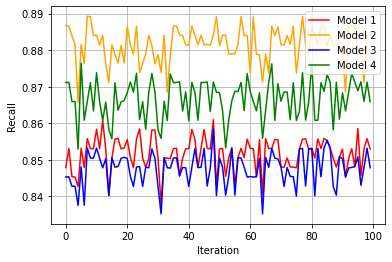

In [145]:
import matplotlib.pyplot as plt

x = [i for i in range(0, 100)]
plt.plot(x, md1res, color = 'red')
plt.plot(x, md2res, color = 'orange')
plt.plot(x, md3res, color = 'blue')
plt.plot(x, md4res, color = 'green')

plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4'])
plt.grid()
plt.show();

Between the first two models I would use the second one, because it has the highest recall values overall compared to model 1. 
As for the 3rd and 4th models I would use the fourth one, again because overall it has higher recall values compared to model 3. 


In [146]:
#defining input and target variables
X_train = telecom_train[['International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
Y_train = telecom_train['Churn']

X_test = telecom_train[['International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
Y_test = telecom_train['Churn']

# min-max transformation
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#rebuilding model 2
md2 = LogisticRegression(solver = 'liblinear', penalty = 'l2').fit(X_train, Y_train)
#predicting on test dataset
md2predict = md2.predict_proba(X_test)[:,1]
#cutoff (10%)
md2labels = np.where(md2predict < .10, 0,1)
#recall score 
md2recall = recall_score(Y_test, md2labels)

#rebuilding model 4
md4 = LogisticRegression(solver = 'saga', penalty = 'l2').fit(X_train, Y_train)
#predicting on test dataset
md4predict = md4.predict_proba(X_test)[:,1]
#cutoff (10%)
md4labels = np.where(md4predict < .10, 0,1)
#recall score 
md4recall = recall_score(Y_test, md4labels)

print('Md2 Recall:', md2recall)
print('Md4 Recall:', md4recall)


Md2 Recall: 0.884020618556701
Md4 Recall: 0.8685567010309279
